In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imsave
import cPickle as pickle
import yaml
import collections
from tqdm import tqdm
import time
from scipy.ndimage.interpolation import zoom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading and interpreting results

In [8]:
base = '/media/michael/Engage/data/audio/bird_audio_detection_challenge/'

if 0:

    import h5py
    h5path = base + '/results/master/predictions/golden_model_second_3_2.h5'
    f = h5py.File(h5path)
    
    res = np.array(f['results'])
    fname_to_res = {fname.split('.')[0]:r for fname, r in zip(fnames, res)}
    
    names = [fname.split('.')[0] for fname in fnames]
    orig_fnames = set('_'.join(name.split('_')[:-1]) for name in names)
else:
    import pandas as pd
    res = pd.read_csv(base + 'results//as_provided_by_author//prediction_first.csv')

In [20]:
fname_to_res = {}
for row in res.iterrows():
    fname_to_res[row[1]['fname']] = row[1]['Unnamed: 1']
    
orig_fnames = set('_'.join(name.split('_')[:-2]) for name in fname_to_res)

print fname_to_res

In [43]:
aggragated_preds = {}

# we're going to chunk up each golden audio file into 10second bits 
overlap_time = 0
chunklength = 0.5

for orig_fname in orig_fnames:
    
    this_res = np.zeros(60.0 / chunklength)
    for start_idx, start_time in enumerate(np.arange(0, 60, chunklength)):
        
        name = orig_fname + '_%05.2f' % start_time 
        name = name.replace('.', '_')
        
        # note - assuming one second gaps
        this_res[start_idx] = fname_to_res[name]
        
    aggragated_preds[orig_fname] = np.zeros_like(this_res)

    aggragated_preds[orig_fname] = this_res

/home/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


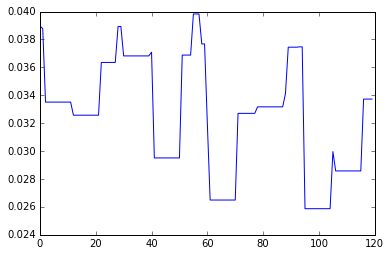

In [36]:
plt.plot(aggragated_preds.values()[0])

# Plotting results with ground truth

In [37]:
# load gt
gts = {}
gt_dir = '/media/michael/Engage/data/audio/alison_data/golden_set/extracted/annotations/'
for fname in aggragated_preds:
    gts[fname] = pickle.load(open(gt_dir + fname + '.pkl'))[0]['biotic']

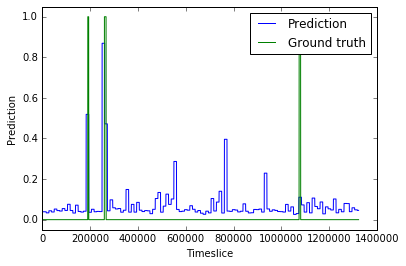

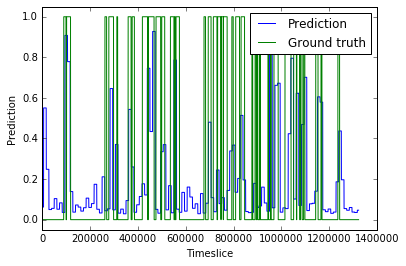

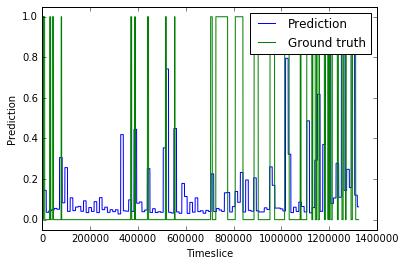

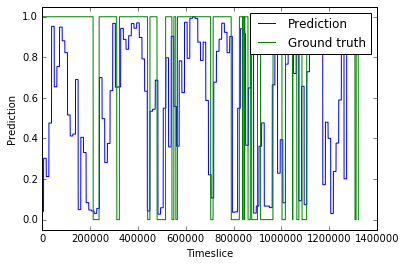

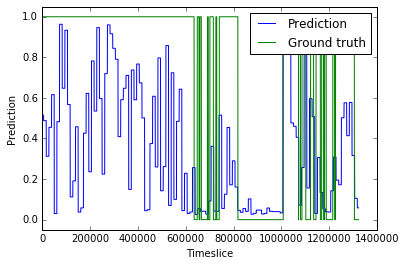

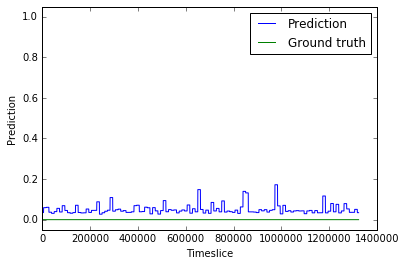

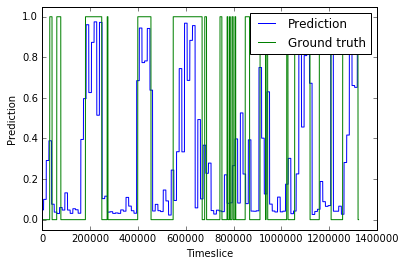

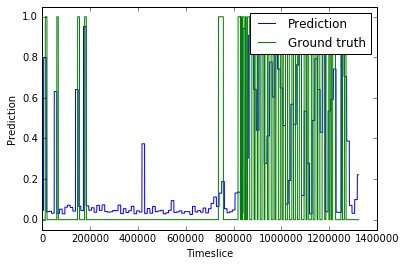

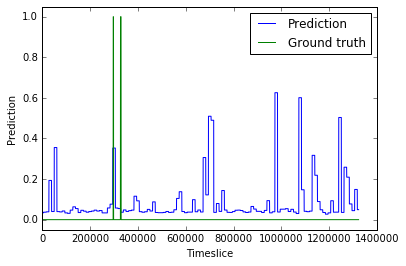

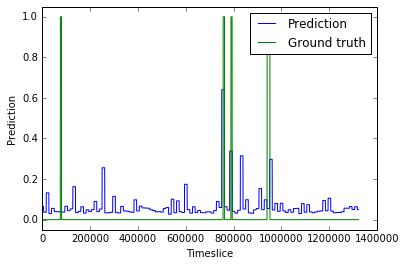

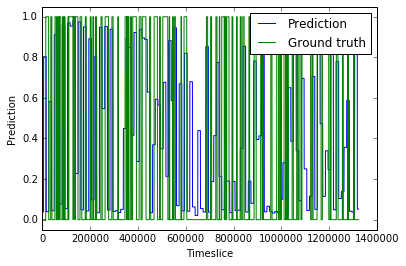

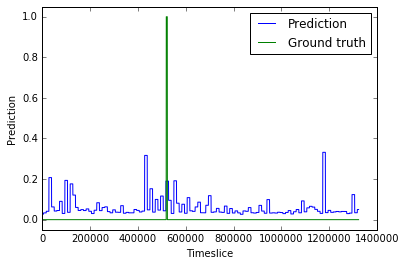

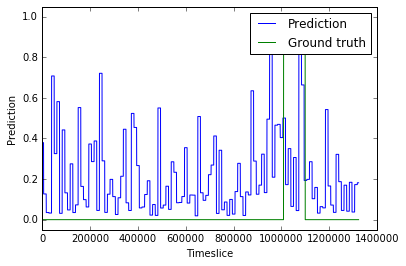

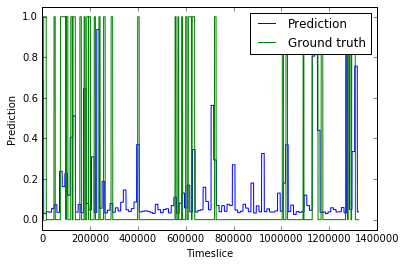

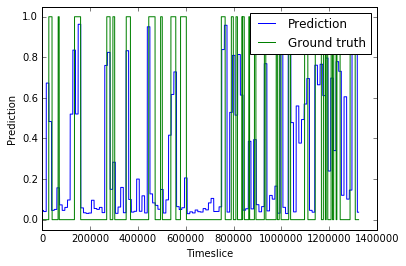

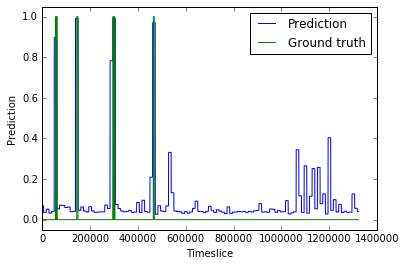

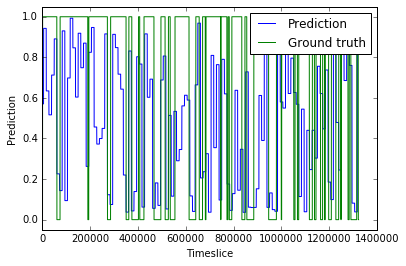

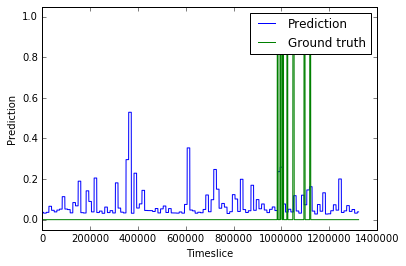

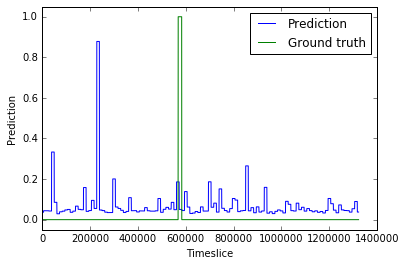

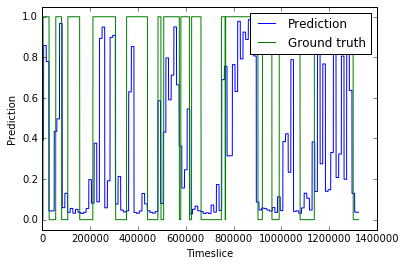

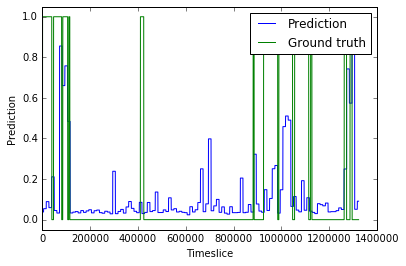

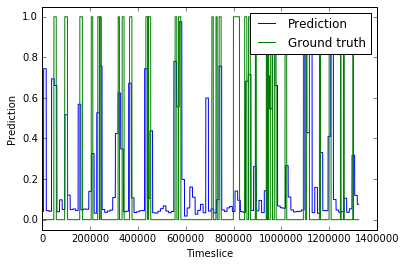

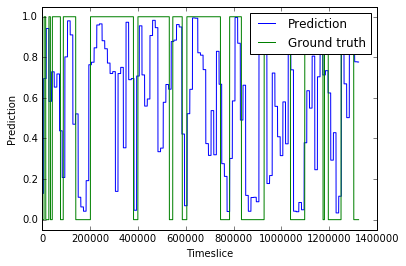

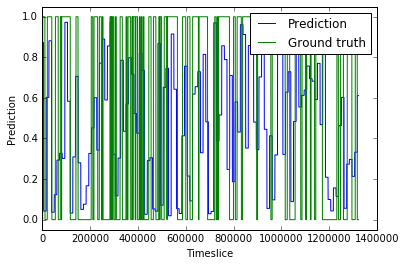

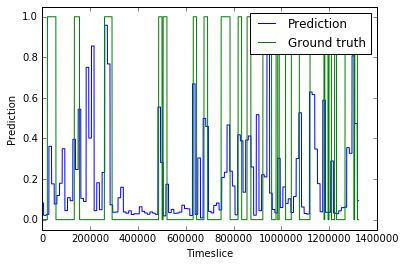

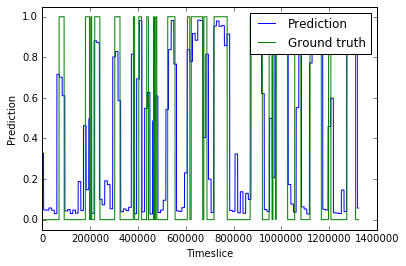

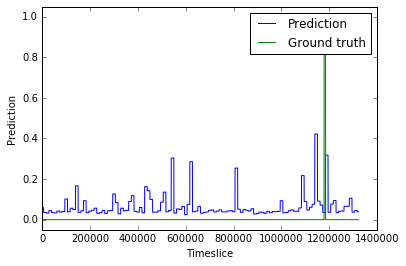

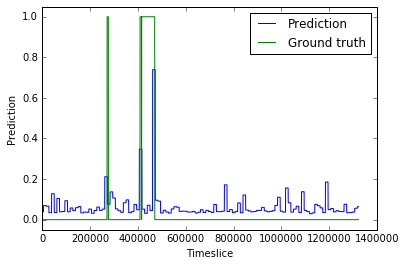

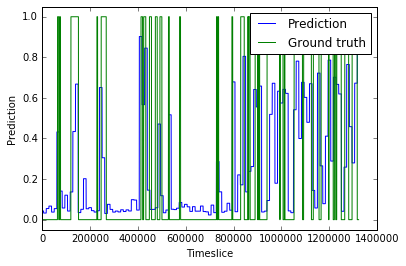

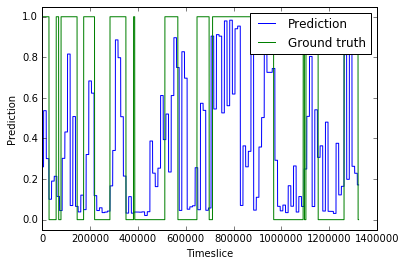

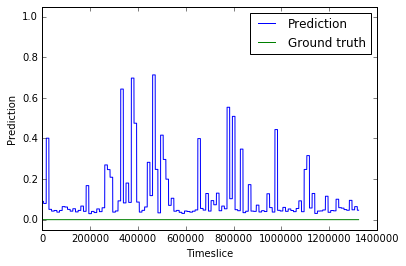

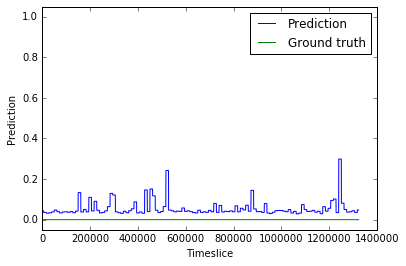

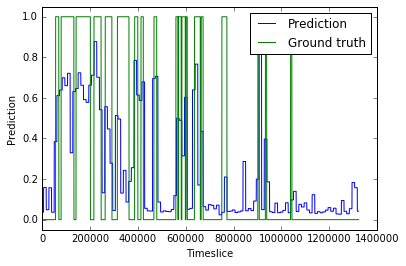

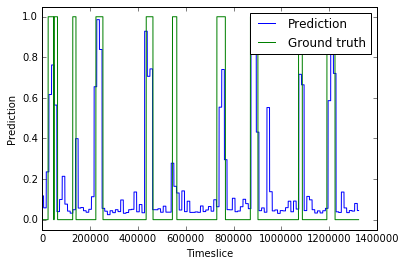

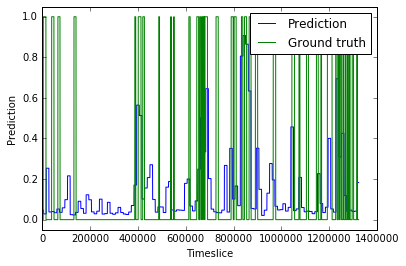

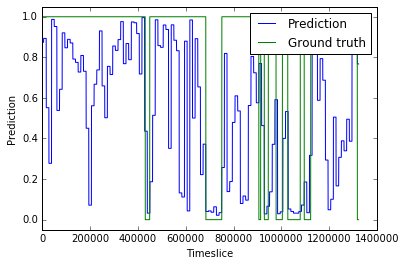

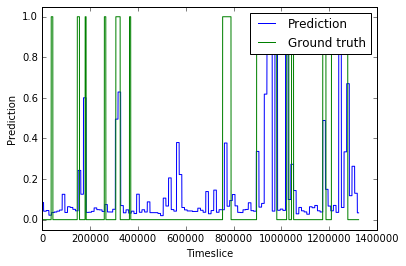

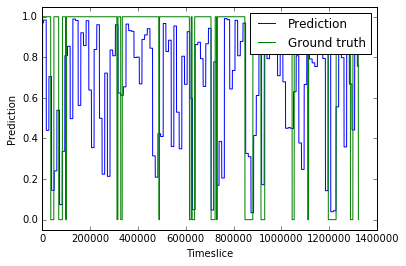

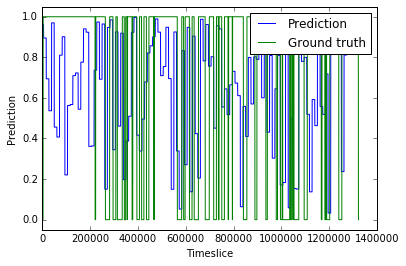

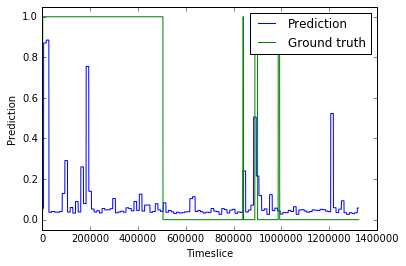

In [44]:
for fname in aggragated_preds.keys():
    plt.figure()

    # plot predicted
    factor = gts[fname].shape[0] / float(aggragated_preds[fname].shape[0])
    pred = zoom(aggragated_preds[fname], factor, order=0)
    plt.plot(pred, label='Prediction')
    
    # plot ground truth
    
    plt.plot(gts[fname], label='Ground truth')
    
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Timeslice')
    plt.ylabel('Prediction')
    plt.legend()

In [45]:
all_preds = []
all_gts = []

for fname in aggragated_preds:

    # plot predicted
    factor = gts[fname].shape[0] / float(aggragated_preds[fname].shape[0])
    pred = zoom(aggragated_preds[fname], factor, order=0)
    
    gts[fname]
    
    all_preds.append(pred)
    all_gts.append(gts[fname])
    
all_preds = np.round(np.hstack(all_preds))
all_gts = np.round(np.hstack(all_gts))

accuracy = np.mean(all_preds == all_gts)
print accuracy

0.810033457216


In [46]:
# class balanced
A = np.mean(all_preds[all_gts > 0.5] == all_gts[all_gts > 0.5])
B = np.mean(all_preds[all_gts < 0.5] == all_gts[all_gts < 0.5])
print (A + B) / 2.0

0.732998582403


In [ ]:
# With overlapping:
# Acc: 0.769
# Balanced acc: 0.684

# With 0.5s chunks:
# Acc: 0.810
# Balanced acc: 0.733


# Us:
# Acc: 86.2
# Balanced: 85.0 